<a href="https://colab.research.google.com/github/dainesjeff/CNN_Implementations/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA IMPORT**

In [ ]:
!unzip './defungi.zip' -d './sample_data/defungi'

Streaming output truncated to the last 5000 lines.
  inflating: ./sample_data/defungi/H1/H1_94a_2.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_3.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_4.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_5.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_6.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_7.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_8.jpg  
  inflating: ./sample_data/defungi/H1/H1_94a_9.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_1.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_2.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_3.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_4.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_5.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_6.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_7.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_8.jpg  
  inflating: ./sample_data/defungi/H1/H1_94b_9.jpg  
  inflating: ./sample_data/defungi/H1/H1_95a_1.j

# **SETUP**

In [ ]:
import os

DATA_DIR = './sample_data/defungi/'

sub_dirs = os.listdir(DATA_DIR)

data_dicts = []
current_label = 0
content_count = 0
for sub_dir in sub_dirs:
  contents_list = os.listdir(DATA_DIR + sub_dir)
  data_dicts.append({"directory": DATA_DIR + sub_dir + '/', "contents": contents_list, "label": current_label})
  current_label += 1
  content_count += len(contents_list)
print(content_count)

9114


In [ ]:
import cv2

image_list = []
label_list = []

for i in data_dicts:
  for image_file in i["contents"]:
    image = cv2.imread(i["directory"] + image_file)
    resized_image = cv2.resize(image, (256, 256))
    image_list.append(resized_image)
    label_list.append(i["label"])

print(len(image_list))

9114


In [ ]:
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(image_list, label_list, test_size=0.2, train_size=0.8)


# **PYTORCH**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform, target_transform=None):
        self.img_labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

tc = transforms.Compose([
        transforms.ToTensor()
    ])


train_dataset = CustomImageDataset(train_y, train_X, tc)
test_dataset = CustomImageDataset(test_y, test_X, tc)

batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn.functional as F
import torch.optim as optim



# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(device)

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5, stride=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 3, 8)
        self.fc1 = torch.nn.Linear(10443, 32)
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN().to(device, non_blocking=True)

objective = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

cuda


In [ ]:
epochs = 8

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

for i in range(epochs):
  train(train_dataloader, net, objective, optimizer)

print('Finished Training')

loss: 1.680947  [   16/ 7291]
loss: 1.252992  [ 1616/ 7291]
loss: 1.513349  [ 3216/ 7291]
loss: 1.462101  [ 4816/ 7291]
loss: 1.169336  [ 6416/ 7291]
loss: 1.441025  [   16/ 7291]
loss: 1.317793  [ 1616/ 7291]
loss: 1.272616  [ 3216/ 7291]
loss: 0.951959  [ 4816/ 7291]
loss: 0.934574  [ 6416/ 7291]
loss: 1.003779  [   16/ 7291]
loss: 1.296250  [ 1616/ 7291]
loss: 1.170419  [ 3216/ 7291]
loss: 1.289368  [ 4816/ 7291]
loss: 1.237530  [ 6416/ 7291]
loss: 1.243251  [   16/ 7291]
loss: 1.422355  [ 1616/ 7291]
loss: 1.459778  [ 3216/ 7291]
loss: 1.193229  [ 4816/ 7291]
loss: 1.282719  [ 6416/ 7291]
loss: 1.295065  [   16/ 7291]
loss: 1.149015  [ 1616/ 7291]
loss: 1.329973  [ 3216/ 7291]
loss: 1.586452  [ 4816/ 7291]
loss: 1.269630  [ 6416/ 7291]
loss: 1.290752  [   16/ 7291]
loss: 1.394698  [ 1616/ 7291]
loss: 1.083140  [ 3216/ 7291]
loss: 1.198913  [ 4816/ 7291]
loss: 1.293034  [ 6416/ 7291]
loss: 1.219935  [   16/ 7291]
loss: 1.178571  [ 1616/ 7291]
loss: 1.263448  [ 3216/ 7291]
loss: 1.08

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.cuda())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
print(f'Accuracy of the network on test data: {100 * correct // total} %')

Accuracy of the network on test data: 49 %


# **TENSORFLOW**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd


model = models.Sequential()
model.add(layers.Conv2D(4, (5, 5), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2, (8, 8), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(5))

model.summary()


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 4)       304       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 2)       514       
                                                                 
 flatten (Flatten)           (None, 28322)             0         
                                                                 
 dense (Dense)               (None, 16)                453168    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                        

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np



onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = np.array(train_y).reshape(len(train_y), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_y = onehot_encoded
train_X = np.array(train_X)

print(train_X.shape)
print(train_y.shape)

integer_encoded = np.array(test_y).reshape(len(test_y), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
test_y = onehot_encoded
test_X = np.array(test_X)

print(test_X.shape)
print(test_y.shape)


(7291, 256, 256, 3)
(7291, 5)
(1823, 256, 256, 3)
(1823, 5)


In [ ]:
history = model.fit(x= train_X, y= train_y, epochs=8, validation_data=(test_X, test_y))

Epoch 1/8
228/228 [==============================] - 13s 25ms/step - loss: 5.7082 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 2/8
228/228 [==============================] - 5s 21ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 3/8
228/228 [==============================] - 5s 20ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 4/8
228/228 [==============================] - 4s 19ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 5/8
228/228 [==============================] - 5s 20ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 6/8
228/228 [==============================] - 4s 19ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch 7/8
228/228 [==============================] - 4s 20ms/step - loss: 5.4051 - accuracy: 0.0801 - val_loss: 5.5525 - val_accuracy: 0.0850
Epoch

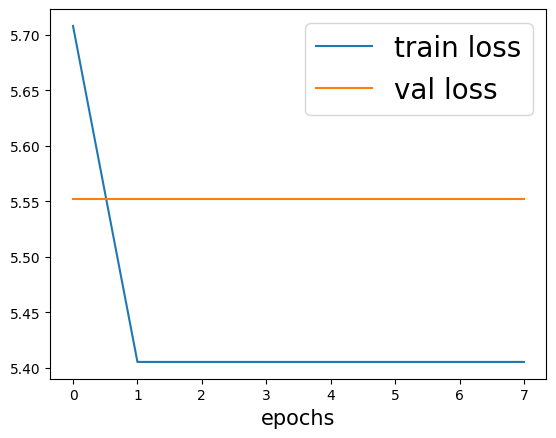

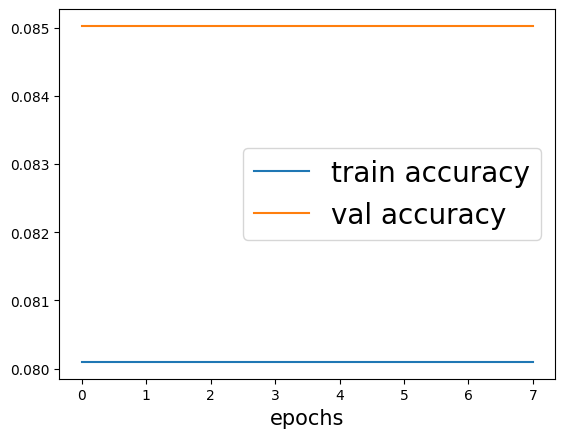

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()